In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
import copy
import numpy as np
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io

In [2]:


def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_left = data[0,:,:] 
    b_right = data[-1,:,:]
    b_upper = data[:,-1,:]
    b_lower = data[:,0,:]
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower



def make_time_sequence(src, num_step=5, step=1e-4):
    dim = num_step
    src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
    for i in range(num_step):
        src[:,i,-1] += step*i
    return src

In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833



torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x):
        x2 = self.act1(x)
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)



class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(PINNsformer, self).__init__()

        self.linear_emb = nn.Linear(2, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        ])

    def forward(self, x, t):
        src = torch.cat((x,t), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        # pdb.set_trace()
        # raise Exception('stop')
        return output

Using cuda


# Convection PDE

The one-dimensional convection problem is a hyperbolic PDE that is commonly used to model transport phenomena. The system has the formulation with periodic boundary conditions as follows:

## Governing Equation
$$\frac{\partial u}{\partial t} + \beta \frac{\partial u}{\partial x} = 0, \quad \forall x \in [0, 2\pi], \, t \in [0, 1]$$

## Initial Condition (IC)
$$u(x, 0) = \sin(x)$$

## Boundary Condition (BC)
$$u(0, t) = u(2\pi, t)$$

In [4]:
# -----------------------------------------------------------------------------
# Training data (collocation + IC + BC)
# -----------------------------------------------------------------------------
T_final = 1
L_finale=2*torch.pi
N_f = 101 # interior collocation points
N_i = 51     # initial‑condition points
N_b = 51    # boundary‑condition points
Beta = 50




# Train PINNsFormer
res, b_t_initial, b_t_final, b_x_end, b_x_start = get_data([0, 2*np.pi], [0, 1], 51, 51)
res_test, _, _, _, _ = get_data([0, 2*np.pi], [0, 1], 101, 101)

# Generate pseudo-sequences for time-stepping
res = make_time_sequence(res, num_step=5, step=1e-4)
b_t_initial = make_time_sequence(b_t_initial, num_step=5, step=1e-4)
b_t_final = make_time_sequence(b_t_final, num_step=5, step=1e-4)
b_x_end = make_time_sequence(b_x_end, num_step=5, step=1e-4)
b_x_start = make_time_sequence(b_x_start, num_step=5, step=1e-4)

# Convert to PyTorch tensors
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_t_initial = torch.tensor(b_t_initial, dtype=torch.float32, requires_grad=True).to(device)
b_t_final = torch.tensor(b_t_final, dtype=torch.float32, requires_grad=True).to(device)
b_x_end = torch.tensor(b_x_end, dtype=torch.float32, requires_grad=True).to(device)
b_x_start = torch.tensor(b_x_start, dtype=torch.float32, requires_grad=True).to(device)

# Separate x and t components
x_res, t_res = res[:, :, 0:1], res[:, :, 1:2]
x_t_initial, t_t_initial = b_t_initial[:, :, 0:1], b_t_initial[:, :, 1:2]
x_t_final, t_t_final = b_t_final[:, :, 0:1], b_t_final[:, :, 1:2]
x_x_end, t_x_end = b_x_end[:, :, 0:1], b_x_end[:, :, 1:2]
x_x_start, t_x_start = b_x_start[:, :, 0:1], b_x_start[:, :, 1:2]



u_i = torch.sin(torch.pi * x_t_initial)










In [29]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)



PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

<ipython-input-29-8f6050db4806>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [38]:
def pde_residual(model: nn.Module, x: torch.Tensor, t: torch.Tensor,a=50):
    """Compute residual f(x,t) = ∂u/∂t + a ∂u/∂x."""
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(x, t)
    # ∂u/∂t
    u_t = torch.autograd.grad(u, t,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True,
                        retain_graph=True )[0]
    # ∂u/∂x
    u_x = torch.autograd.grad(u, x,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True,
                        retain_graph=True )[0]

    return u_t + a * u_x  # residual should be ≈ 0

In [45]:
def loss_components(model):
    """Returns individual MSE losses: residual, IC, BC."""
    f = pde_residual(model, x_res, t_res,Beta)

    u_pred_i = model(x_t_initial, t_t_initial)


    u_pred_b_start = model(x_x_start, t_x_start)
    
    u_pred_b_end = model(x_x_end, t_x_end)


    loss_f = torch.mean(f ** 2)
    loss_i = torch.mean((u_pred_i[:,0] - torch.sin(x_t_initial[:,0])) ** 2)
    loss_b = torch.mean((u_pred_b_start - u_pred_b_end) ** 2)


    return loss_f, loss_i, loss_b

In [30]:
loss_track = []

for i in tqdm(range(500)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_end = model(x_x_end, t_x_end)
        pred_start = model(x_x_start, t_x_start)

        pred_initial = model(x_t_initial, t_t_initial)
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t + 50 * u_x) ** 2)
        loss_bc = torch.mean((pred_end - pred_start) ** 2)
        loss_ic = torch.mean((pred_initial[:,0] - torch.sin(x_t_initial[:,0])) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss
    
    optim.step(closure)

100%|██████████| 500/500 [07:40<00:00,  1.09it/s]


In [33]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.000001, Loss_BC: 0.000064, Loss_IC: 0.000007
Train Loss: 0.000072


In [47]:

model2 = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model2.apply(init_weights)

optim2 = LBFGS(model2.parameters(), line_search_fn='strong_wolfe')

def closure():
    optim2.zero_grad()
    lf, li, lb = loss_components(model2)  # All model calls and loss calculations inside
    loss = lf + li + lb
    loss.backward()
    return loss



for i in tqdm(range(500)):
    optim2.step(closure)
    # If you want to print losses, recompute them OUTSIDE the closure, not inside
    if i % 50 == 0:
        lf, li, lb = loss_components(model2)
        loss = lf + li + lb
        print(f"Step {i}: total={loss.item()} (res={lf.item()}, IC={li.item()}, BC={lb.item()})")

        
        

<ipython-input-29-8f6050db4806>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:01<09:10,  1.10s/it]

Step 0: total=0.5122129917144775 (res=0.0195306483656168, IC=0.4923877418041229, BC=0.00029464124236255884)


 10%|█         | 51/500 [01:08<10:03,  1.34s/it]

Step 50: total=0.31882694363594055 (res=0.005227609537541866, IC=0.25601330399513245, BC=0.057586051523685455)


 20%|██        | 101/500 [02:14<08:54,  1.34s/it]

Step 100: total=0.30657267570495605 (res=0.006643223576247692, IC=0.24496565759181976, BC=0.05496379733085632)


 30%|███       | 151/500 [03:21<07:31,  1.29s/it]

Step 150: total=0.06694258749485016 (res=0.009478764608502388, IC=0.013601270504295826, BC=0.04386255517601967)


 40%|████      | 201/500 [04:26<06:27,  1.29s/it]

Step 200: total=0.03132990375161171 (res=0.0010828326921910048, IC=0.002798545639961958, BC=0.02744852565228939)


 50%|█████     | 251/500 [05:31<05:27,  1.32s/it]

Step 250: total=0.023211022838950157 (res=0.0008691379916854203, IC=0.001235458068549633, BC=0.021106427535414696)


 60%|██████    | 301/500 [06:38<04:22,  1.32s/it]

Step 300: total=0.018851781263947487 (res=0.00080751848872751, IC=0.0008008892182260752, BC=0.01724337413907051)


 70%|███████   | 351/500 [07:45<03:20,  1.35s/it]

Step 350: total=0.013465852476656437 (res=0.00034935580333694816, IC=0.00045717990724369884, BC=0.012659316882491112)


 80%|████████  | 401/500 [08:51<02:09,  1.30s/it]

Step 400: total=0.009287240915000439 (res=0.00014141789870336652, IC=0.00026195545797236264, BC=0.008883867412805557)


 90%|█████████ | 451/500 [09:57<01:04,  1.32s/it]

Step 450: total=0.007219885941594839 (res=0.00016739593411330134, IC=0.00023767331731505692, BC=0.006814816500991583)


100%|██████████| 500/500 [11:01<00:00,  1.32s/it]


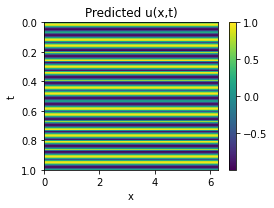

In [56]:
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 15, 15)


# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]


with torch.no_grad():
    pred = model2(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinnsformer_pred.png')
plt.show()


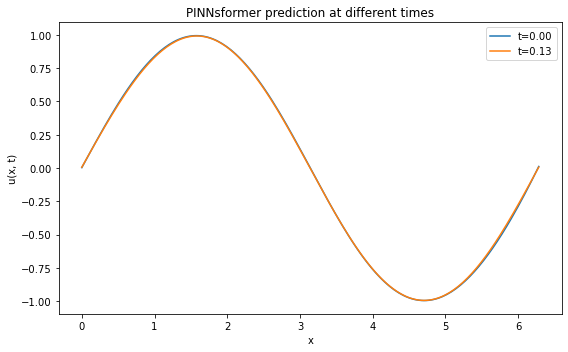

In [59]:
# Define the time snapshots you want to plot
time_snapshots = [0.0,0.1256]
x_points = 200
num_step = 5
step = 1e-4

x_vals = np.linspace(0, 2 * np.pi, x_points)

plt.figure(figsize=(8, 5))

for t_val in time_snapshots:
    # Create (x, t) pairs for this snapshot
    x_grid = np.expand_dims(x_vals, axis=1)
    t_grid = np.full_like(x_grid, t_val)
    xt = np.concatenate([x_grid, t_grid], axis=1)  # shape (x_points, 2)
    # Use make_time_sequence to create the sequence
    xt_seq = make_time_sequence(xt, num_step=num_step, step=step)  # shape (x_points, num_step, 2)
    xt_seq_tensor = torch.tensor(xt_seq, dtype=torch.float32).to(device)
    # Split into x and t for the model
    x_seq = xt_seq_tensor[:, :, 0:1]
    t_seq = xt_seq_tensor[:, :, 1:2]
    with torch.no_grad():
        u_pred = model2(x_seq, t_seq)[:, 0, 0].cpu().numpy()  # Take the first in the sequence
    plt.plot(x_vals, u_pred, label=f"t={t_val:.2f}")

plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('PINNsformer prediction at different times')
plt.legend()
plt.tight_layout()

plt.show()